In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn import tree
from IPython.display import Image
import pydotplus
import graphviz
%matplotlib inline

Weak learner 0 R^2: -21.86595826514709
Weak learner 20 R^2: -0.0026192923008196978
Weak learner 40 R^2: -0.0016748172727343302
Weak learner 60 R^2: -0.0014818633549411597
Weak learner 80 R^2: -0.0012578370480089696
Weak learner 100 R^2: -0.0007136861925909344


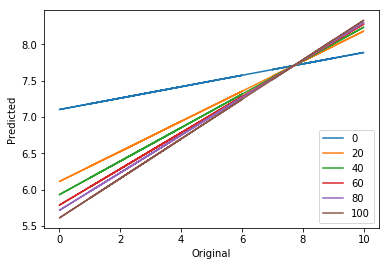

Overall R^2:
0.5282873581794291


In [2]:
# Working with the European Social Survey data again.
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()

# Define outcome and predictors.
y = df['happy']
X = df.loc[:, ~df.columns.isin(['happy', 'cntry'])]

# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# Store values from loops.
preds = pd.DataFrame()
labels = []

uniquex = df['happy'].unique()

# Iterate through decision trees, each time using the residuals
# from the previous tree as the inputs.
for m in range(0, 101):
    
    # Initialize and fit the tree. Set the max depth to 2.
    decision_tree = tree.DecisionTreeRegressor(max_depth=2)
    decision_tree.fit(X,y)
    
    # Get and store predicted values.
    pred = decision_tree.predict(X)
    preds['pred{}'.format(m)] = pred
    
    # Residuals.
    y = y - pred

    # Output every 20 iterations.
    if m % 20 == 0:
        print('Weak learner {} R^2: {}'.format(m, decision_tree.score(X, y)))
        labels = labels + [m]
        bestpred = preds.sum(axis=1)
        plt.plot(uniquex, np.poly1d(np.polyfit(df['happy'], bestpred, 1))(uniquex))
       
plt.legend(labels)
plt.xlabel('Original')
plt.ylabel('Predicted')
plt.show()
predicted = preds.sum(axis=1)

print('Overall R^2:')
print(np.corrcoef(df['happy'], predicted)[0, 1])


In [5]:
#Let's try this with just one big decision tree rather than boosting


One strongish learner R^2: 0.06711108322936532


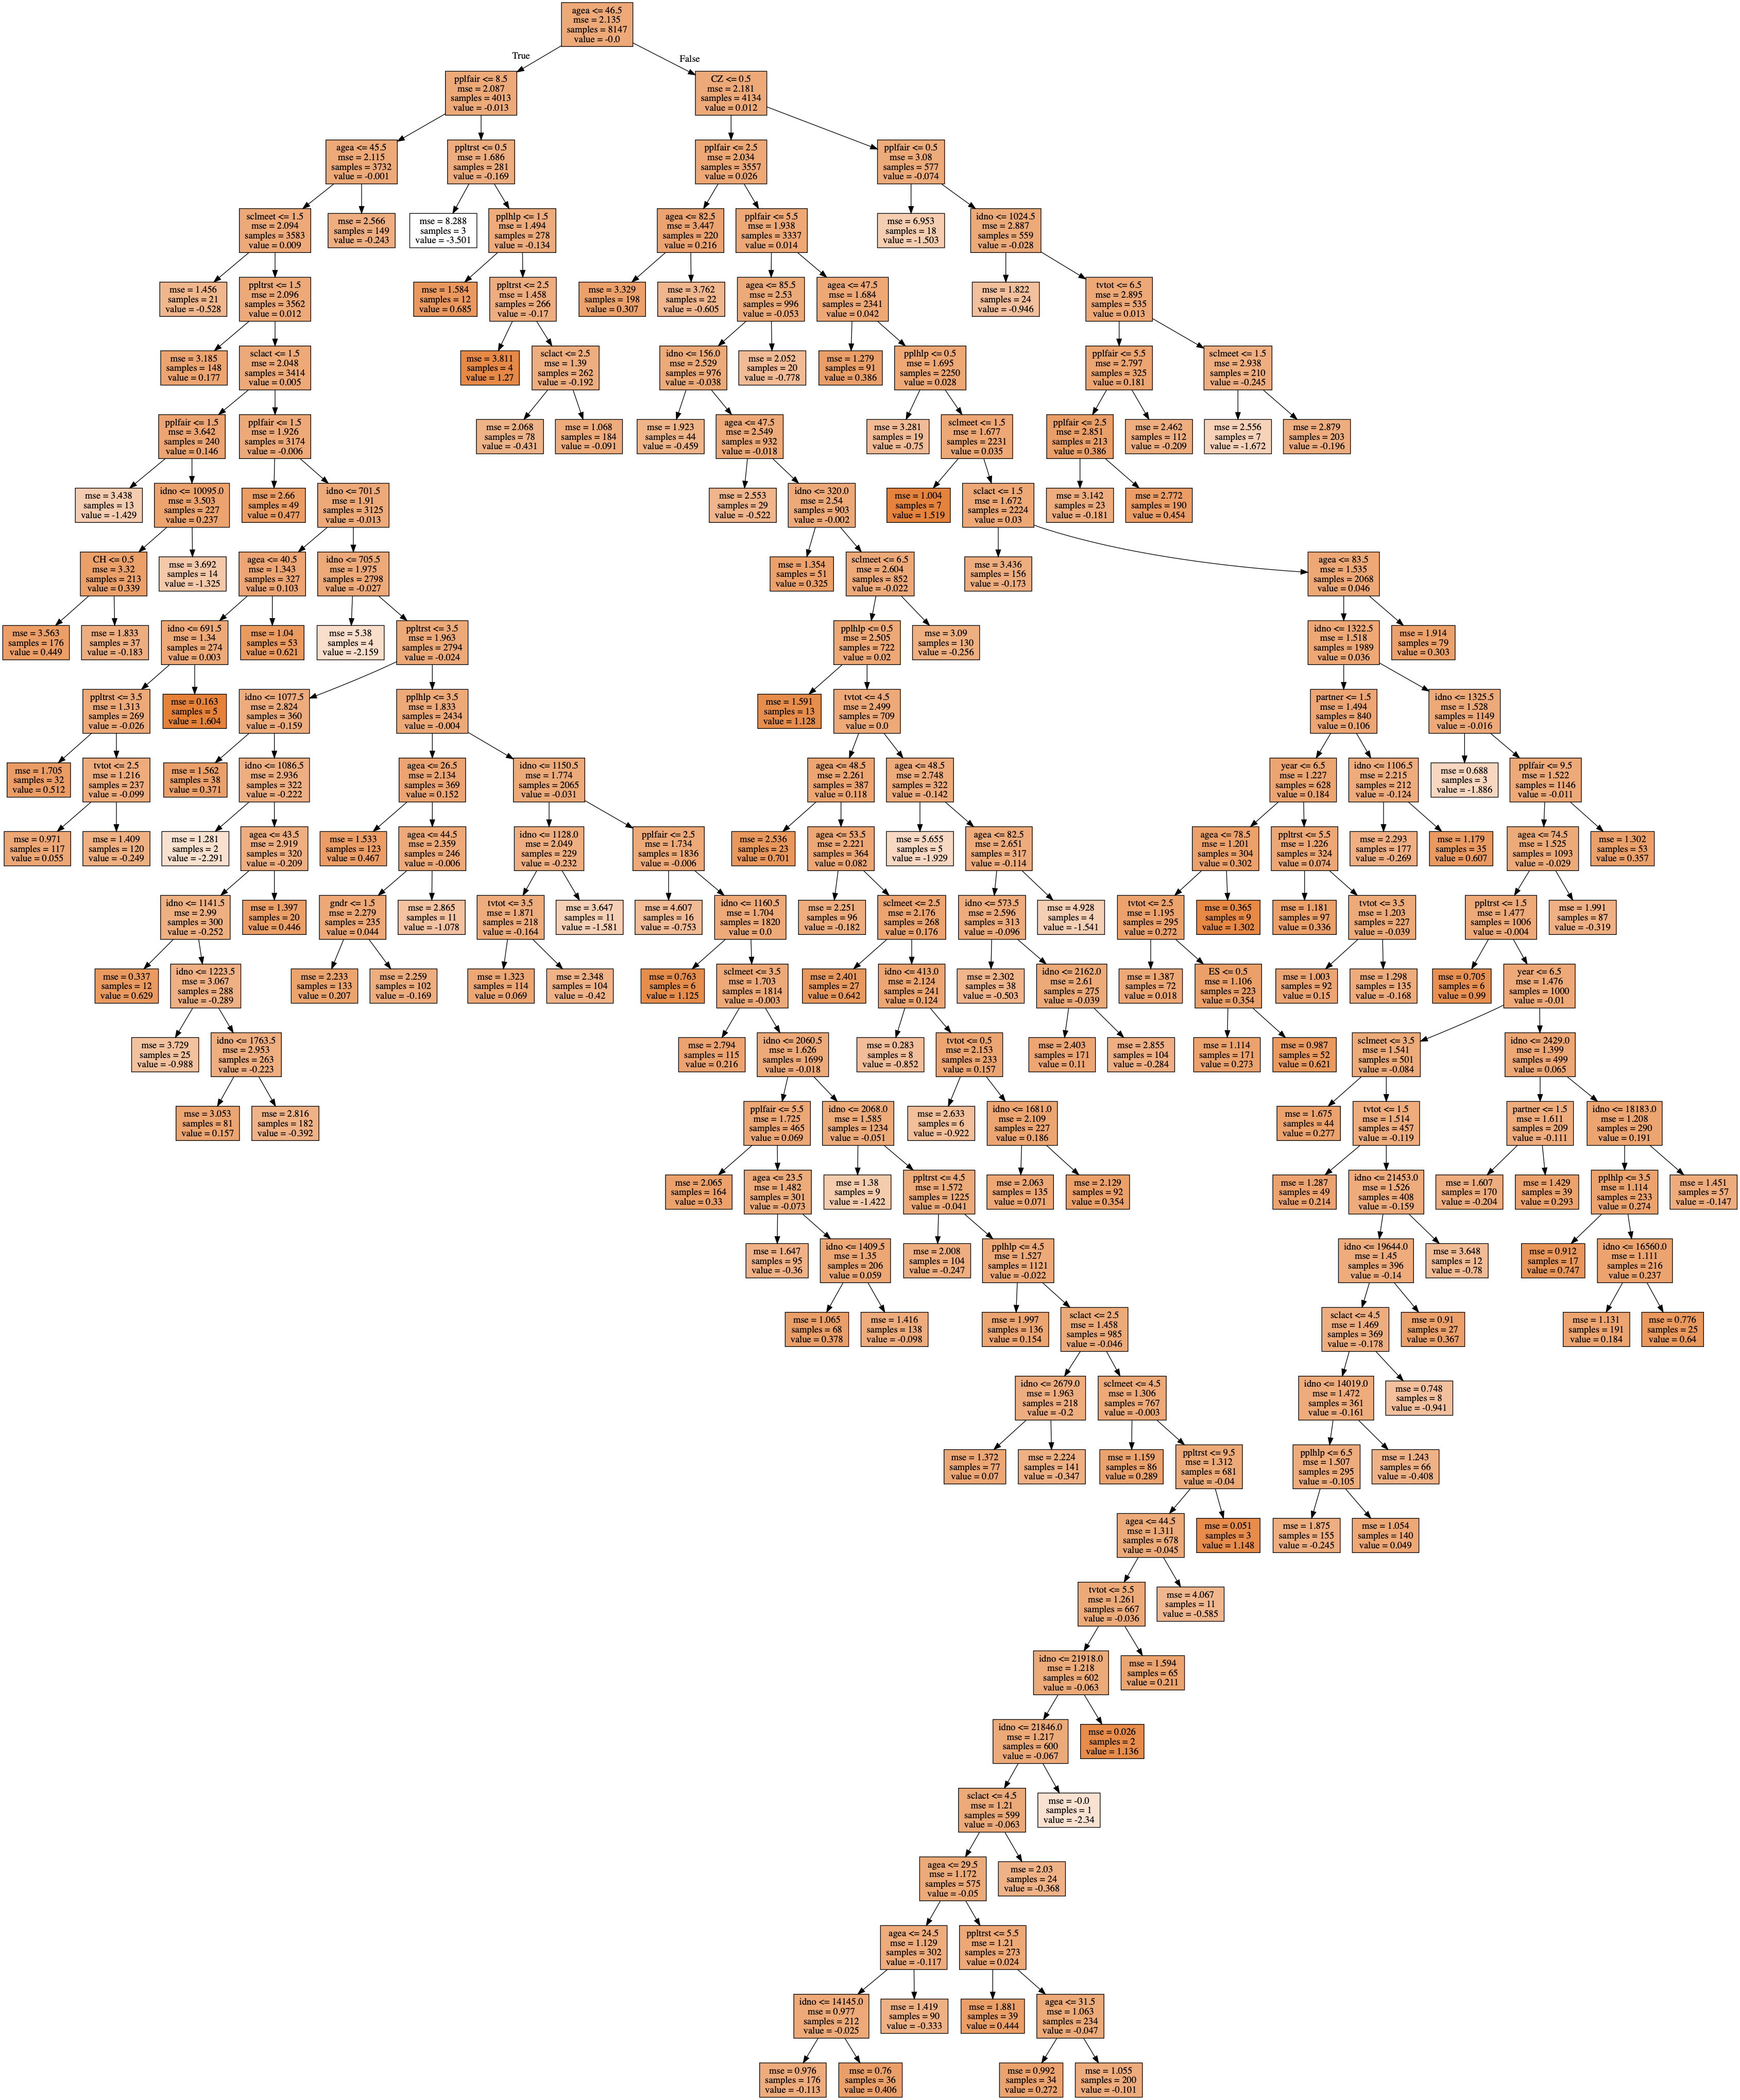

In [6]:
# One big tree. Each node split will include at lest 2.5% of the total sample.
decision_tree = tree.DecisionTreeRegressor(min_samples_split=.025)
decision_tree.fit(X,y)

#Get and store predicted values.
pred = decision_tree.predict(X)
print('One strongish learner R^2: {}'.format(decision_tree.score(X, y)))

dot_data = tree.export_graphviz(decision_tree, out_file=None,
                                feature_names=X.columns,  
                                filled=True) 
graph = pydotplus.graph_from_dot_data(dot_data) 
Image(graph.create_png())  

In [7]:
#That was awful, essentially 10x less effective and more prone to overfitting

In [86]:
#We did it manually but now lets use SKLearn

In [9]:
from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from scipy import stats

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [55]:
#Now with a categorical outcome: Whether or not someone lives with a partner.

df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()

#First remove some outliers from our data (This command removed about 130 rows)
df= df[(np.abs(stats.zscore(df.loc[:, ~df.columns.isin(['cntry', 'gndr', 'partner'])])) <= 3).all(axis=1)]

# Definine outcome and predictors.
# Set our outcome to 0 and 1.
y = df['partner'] - 1
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]

# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# Create training and test sets.
offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:]

In [83]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 1000,
          'max_depth': 4,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

clf.score(X_train, y_train)


Training set accuracy:
Percent Type I errors: 0.010252147409254642
Percent Type II errors: 0.07813798836242726

Test set accuracy:
Percent Type I errors: 0.09476309226932668
Percent Type II errors: 0.18329177057356608


0.9116098642283181

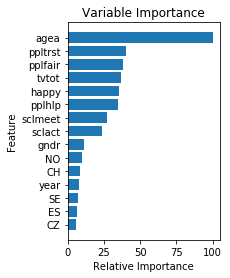

In [84]:
#We can get a measure of how important various features are by 
#counting how many times a feature is used over the course of many decision trees.

feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
plt.title('Variable Importance')
plt.show()

In [74]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf, X_train, y_train, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.66 (+/- 0.19)
